# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [ ]:
# IMPORTS
%load_ext autoreload
%autoreload 2

import csv, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tasks.task import Task
from tasks.takeoff import Takeoff
from agents.basic_agent import Basic_Agent, Trivial_Takeoff_Agent
from agents.policy_search import PolicySearch_Agent
from agents.ddpg_agent import DDPG

# log and plot helper
import utility

In [ ]:
### TRIVIAL TEST ###

# Modify the values below to give the quadcopter a different starting position.

runtime = 25.                                     # time limit of the episode
init_pose = np.array([0., 0., 100., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0.0, 0.0, 100.0])
file_output = 'trivial_takeoff_data.txt'                    # file name for saved results

# Setup
task = Takeoff(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
noise = 0
speed = 404
agent = Trivial_Takeoff_Agent(task, speed, noise)
# Run the simulation, and save the results.
results = utility.log_run(agent, file_output)
utility.plot_run(results)
utility.print_3d_trajectory(results)

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [ ]:
### BASIC AGENT ###

# Modify the values below to give the quadcopter a different starting position.

runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0.0, 0.0, 10.0])
file_output = 'basic_agent_data.txt'                    # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = Basic_Agent(task)
# Run the simulation, and save the results.
results = utility.log_run(agent, file_output)
utility.plot_run(results)

In [ ]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

#### POLICY SEARCH AGENT

In [ ]:
### Training

num_episodes = 100
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 0., 0., 0., 0.])  # initial pose
target_pos = np.array([0., 0., 100.])
task = Takeoff(init_pose=init_pose, target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

This agent should perform very poorly on this task.  And that's where you come in!

In [ ]:
### Evaluation

file_output = 'plolicy_search_agent_data.txt'                    # file name for saved results

# Setup
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 
utility.plot_run(results)
utility.print_3d_trajectory(results)

## Test Noise

In [ ]:
# UNDERSTANDING ORNSTEIN UHLENBECK NOISE #
from agents.ounoise import OUNoise

def plot_noise_process():
    %matplotlib inline
    # Noise process
    action_size = 1
    mu = 0.0
    theta = 0.03
    sigma = .0005
    noise_gen = OUNoise(action_size, mu, theta, sigma)

    noise = [noise_gen.sample() for _ in range(25)]

    plt.plot(noise)
    plt.show()
    
plot_noise_process()

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

### General Imports

In [142]:
import autoreload

%load_ext autoreload
%autoreload 2

import sys, csv, time, random
import numpy as np
np.random.seed(163758683)

import pandas as pd
import matplotlib.pyplot as plt

from agents.ddpg_agent import DDPG
from agents.ounoise import OUNoise
from agents.replay_buffer import ReplayBuffer
from tasks.task import Task
from tasks.takeoff import Takeoff
from tasks.landing import Landing
from tasks.hovering import Hovering
import utility

gen_num_episodes = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. TASK - TAKEOFF

In [131]:
%matplotlib notebook

num_episodes = 100
num_episodes = num_episodes if num_episodes else gen_num_episodes

# Takeoff task
# Quadcopter starts on (0,0,0) and has as target (0,0,100)

init_pos = np.array([0., 0., 0., 0., 0., 0.])
target_pos = np.array([0., 0., 100.])
takeoff = Takeoff(init_pose=init_pos, target_pos=target_pos)

# Agent
params = {}
params['dropout_rate'] = 0.3
params['sigma'] = 0.01
takeoff_agent = DDPG(takeoff, params)

# Scores for plotting
display_every = 1
y_lims_reward = [-1000.,30000.]

np.random.seed(47621347)

%matplotlib notebook
takeoff_scores, xs, ys1, ys2 = utility.train(takeoff_agent, takeoff, num_episodes, display_every, False, y_lims_reward)

Number of episodes:  100

Epi=   1, score=12692.232, (best=12692.232), reward=49.33, penalty=50.67, pos=-19.53 -10.91 5.6, v=-11.06 -4.62 -9.72
penalties:  pos_x: 381.49  pos_y: 119.13  pos_z: 8911.18  euler: 5.85  v_x: 122.24  v_y: 21.34  v_z: 10839.97  av_p: 0.0  av_t: 69.98925062446445  pos: 89612.44  velo: 10983.54  av_all: 150.64  all: 101331.44

Epi=   2, score=673.797, (best=12692.232), reward=44.59, penalty=55.41, pos=-0.02 0.22 0.0, v=-0.35 1.68 -1.71
penalties:  pos_x: 0.0  pos_y: 0.05  pos_z: 10000.0  euler: 4.59  v_x: 0.12  v_y: 2.81  v_z: 10344.14  av_p: 0.0  av_t: 0.5628207023970998  pos: 100000.05  velo: 10347.07  av_all: 7.93  all: 110814.51

Epi=   3, score=404.198, (best=12692.232), reward=44.66, penalty=55.34, pos=-0.01 0.08 0.0, v=-0.21 1.01 -0.94
penalties:  pos_x: 0.0  pos_y: 0.01  pos_z: 10000.0  euler: 4.76  v_x: 0.04  v_y: 1.02  v_z: 10188.64  av_p: 0.0  av_t: 0.45869345809681744  pos: 100000.01  velo: 10189.7  av_all: 10.82  all: 110676.85

Epi=   4, score=403


Epi=  28, score=20347.773, (best=20347.773), reward=98.56, penalty=1.44, pos=-22.61 9.08 90.61, v=13.73 -3.19 -2.31
penalties:  pos_x: 511.14  pos_y: 82.44  pos_z: 88.11  euler: 10.07  v_x: 188.51  v_y: 10.15  v_z: 136.91  av_p: 0.0  av_t: 70.1045807074332  pos: 1474.67  velo: 335.58  av_all: 70.52  all: 2887.31

Epi=  29, score=22628.152, (best=22628.152), reward=198.07, penalty=1.93, pos=3.96 -6.46 112.57, v=0.38 -1.25 29.58
penalties:  pos_x: 15.66  pos_y: 41.73  pos_z: 157.99  euler: 1.02  v_x: 0.14  v_y: 1.56  v_z: 1776.58  av_p: 0.0  av_t: 8.898866778777194  pos: 1637.3  velo: 1778.28  av_all: 22.9  all: 3856.59

Epi=  30, score=22854.805, (best=22854.805), reward=197.08, penalty=2.92, pos=5.0 7.42 114.16, v=1.73 20.4 31.78
penalties:  pos_x: 24.95  pos_y: 55.0  pos_z: 200.48  euler: 7.97  v_x: 3.01  v_y: 416.29  v_z: 2110.19  av_p: 0.0  av_t: 5.6155269593602535  pos: 2084.78  velo: 2529.49  av_all: 18.77  all: 5831.2

Epi=  31, score=23034.843, (best=23034.843), reward=196.23, 


Epi=  54, score=22366.070, (best=24152.869), reward=199.02, penalty=0.98, pos=-20.25 -5.98 101.92, v=-23.73 6.03 -3.22
penalties:  pos_x: 409.92  pos_y: 35.71  pos_z: 3.67  euler: 8.45  v_x: 563.34  v_y: 36.39  v_z: 1.69  av_p: 0.0  av_t: 31.163222268394644  pos: 482.33  velo: 601.42  av_all: 33.55  all: 1969.97

Epi=  55, score=23155.821, (best=24152.869), reward=198.44, penalty=1.56, pos=-1.73 -5.69 111.18, v=-4.78 -2.74 26.61
penalties:  pos_x: 2.98  pos_y: 32.4  pos_z: 124.99  euler: 1.16  v_x: 22.9  v_y: 7.51  v_z: 1427.95  av_p: 0.0  av_t: 1.6880868160173728  pos: 1285.27  velo: 1458.36  av_all: 10.24  all: 3119.58

Epi=  56, score=22823.001, (best=24152.869), reward=197.65, penalty=2.35, pos=2.07 -5.27 114.63, v=-5.42 -0.79 29.38
penalties:  pos_x: 4.28  pos_y: 27.76  pos_z: 214.01  euler: 0.96  v_x: 29.41  v_y: 0.62  v_z: 1936.88  av_p: 0.0  av_t: 20.367614749591585  pos: 2172.16  velo: 1966.91  av_all: 44.89  all: 4707.93

Epi=  57, score=22953.007, (best=24152.869), reward=1


Epi=  80, score=20353.897, (best=24152.869), reward=98.54, penalty=1.46, pos=-25.47 1.34 92.81, v=-12.85 14.75 -12.42
penalties:  pos_x: 648.95  pos_y: 1.79  pos_z: 51.7  euler: 9.26  v_x: 165.03  v_y: 217.47  v_z: 384.69  av_p: 0.0  av_t: 42.84564519632565  pos: 1167.77  velo: 767.2  av_all: 52.71  all: 2913.71

Epi=  81, score=23165.679, (best=24152.869), reward=198.43, penalty=1.57, pos=-4.2 -5.21 111.16, v=-10.44 -3.17 25.11
penalties:  pos_x: 17.64  pos_y: 27.19  pos_z: 124.52  euler: 1.58  v_x: 108.98  v_y: 10.04  v_z: 1315.47  av_p: 0.0  av_t: 5.197491391098271  pos: 1290.05  velo: 1434.49  av_all: 14.61  all: 3145.91

Epi=  82, score=22656.817, (best=24152.869), reward=199.22, penalty=0.78, pos=-18.63 -0.09 103.7, v=-24.63 -6.09 -1.96
penalties:  pos_x: 346.93  pos_y: 0.01  pos_z: 13.7  euler: 3.65  v_x: 606.66  v_y: 37.05  v_z: 3.05  av_p: 0.0  av_t: 28.839410005899108  pos: 483.97  velo: 646.75  av_all: 29.81  all: 1552.68

Epi=  83, score=23215.781, (best=24152.869), reward

### 2. Task: Takeoff - Plot Scores / Single Episode Evaluation

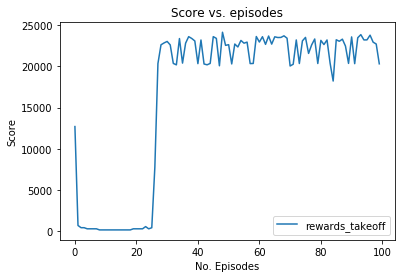

final_reward:  589.9533138730178


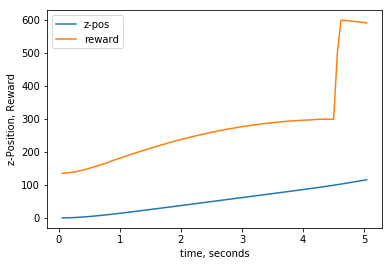

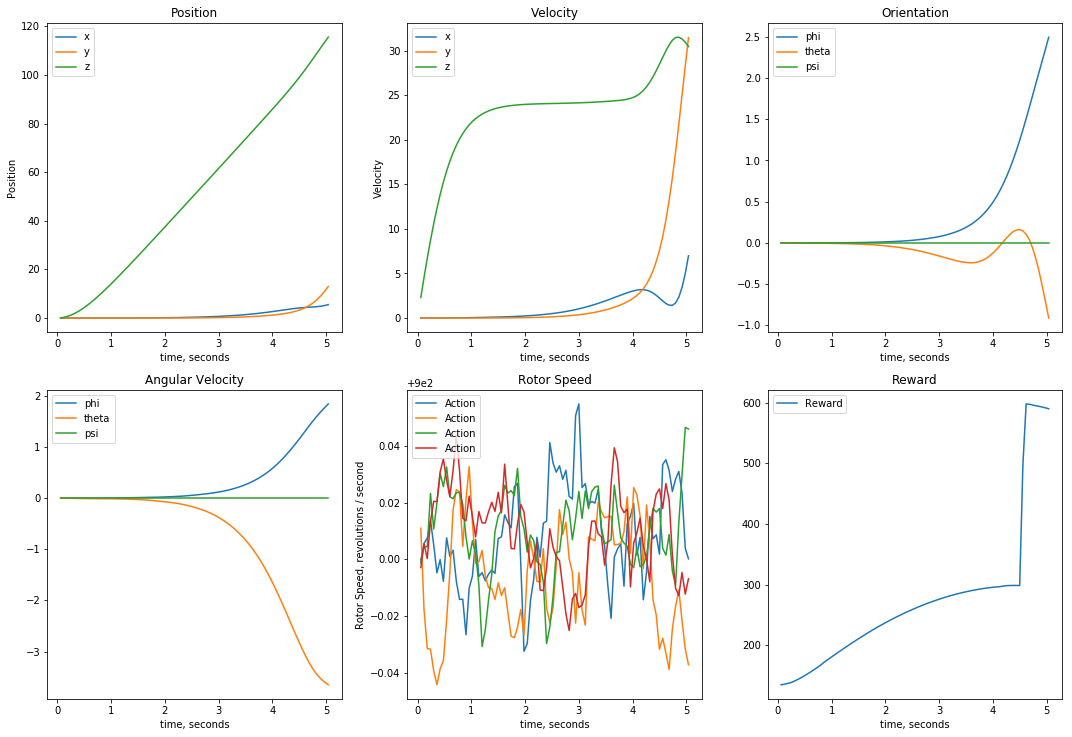

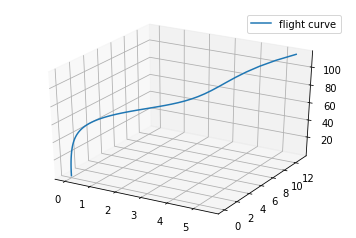

In [132]:
%matplotlib inline
utility.evaluate_episode(takeoff_agent, takeoff_scores, "takeoff")

#### END TASK TAKEOFF

## 2. TASK - LANDING

In [139]:
%matplotlib notebook

num_episodes = 100
num_episodes = num_episodes if num_episodes else gen_num_episodes

# Landing task
# Quadcopter starts on (0,0,100) and has as target (0,0,0)

init_pos = np.array([0., 0., 100., 0., 0., 0.])
init_velocities = np.array([0.0, 0.0, 0.0])
target_pos = np.array([0., 0., 0.])
landing = Landing(init_pose=init_pos, init_velocities=init_velocities, target_pos=target_pos, runtime=5.)

params = {}
params['sigma'] = 0.1
params['dropout_rate'] = 0.2
params['size_multiplicator'] = 2
params['batch_size'] = 64
params['batch_norm'] = False

# Agent
landing_agent = DDPG(landing, params)

# Scores for plotting
display_every = 1
y_lims_reward = [-7000000.,0.]

np.random.seed(75800345)

landing_scores, xs, ys1, ys2 = utility.train(landing_agent, landing, num_episodes, display_every, False, y_lims_reward)

Number of episodes:  100

Epi=   1, score=-185158.910, (best=-185158.910), reward=-63.36, penalty=163.36, pos=-35.09 17.98 38.29, v=-11.36 10.39 -47.4
penalties:  pos_xy: 1554.39  pos_z: 1466.23  euler: 3.8  v_x: 11.36  v_y: 10.39  v_z: -47.4  pos: 16216.67  velo: -25.65

Epi=   2, score=-97966.055, (best=-97966.055), reward=-52.23, penalty=152.23, pos=-0.08 113.33 14.38, v=0.51 113.57 74.65
penalties:  pos_xy: 12844.01  pos_z: 206.74  euler: 3.5  v_x: 0.51  v_y: 113.57  v_z: 74.65  pos: 14911.46  velo: 188.73

Epi=   3, score=-326029.072, (best=-97966.055), reward=-182470.51, penalty=182570.51, pos=0.0 -0.0 0.0, v=0.0 -0.0 -1510.73
penalties:  pos_xy: 0.0  pos_z: 0.0  euler: 0.0  v_x: 0.0  v_y: 0.0  v_z: -1510.73  pos: 0.0  velo: -1510.73  extra_v_penalty_1: 9129280.9609  extra_v_penalty_2: 9129280.9609

Epi=   4, score=-326571.797, (best=-97966.055), reward=-182475.67, penalty=182575.67, pos=0.0 0.0 0.0, v=0.0 0.01 -1510.74
penalties:  pos_xy: 0.0  pos_z: 0.0  euler: 6.28  v_x: 0.0  


Epi=  29, score=-100642.729, (best=-97966.055), reward=42.86, penalty=57.14, pos=0.0 10.75 0.0, v=0.0 3.22 -37.28
penalties:  pos_xy: 115.6  pos_z: 0.0  euler: 2.73  v_x: 0.0  v_y: 3.22  v_z: -37.28  pos: 115.6  velo: -34.06  extra_v_penalty_1: 5557.702499999999  extra_v_penalty_2: 9070.657599999999

Epi=  30, score=-101522.996, (best=-97966.055), reward=46.03, penalty=53.97, pos=-0.0 14.71 0.0, v=-0.0 7.17 -32.23
penalties:  pos_xy: 216.32  pos_z: 0.0  euler: 10.25  v_x: 0.0  v_y: 7.17  v_z: -32.23  pos: 216.32  velo: -25.06  extra_v_penalty_1: 4153.802500000001  extra_v_penalty_2: 9070.657599999999

Epi=  31, score=-102050.390, (best=-97966.055), reward=-87.66, penalty=187.66, pos=-0.0 11.61 0.0, v=-0.0 9.37 -66.28
penalties:  pos_xy: 134.86  pos_z: 0.0  euler: 10.58  v_x: 0.0  v_y: 9.37  v_z: -66.28  pos: 134.86  velo: -56.91  extra_v_penalty_1: 17569.502500000002  extra_v_penalty_2: 9070.657599999999

Epi=  32, score=-101721.748, (best=-97966.055), reward=-119.2, penalty=219.2, po


Epi=  56, score=-97820.096, (best=-95891.174), reward=26.82, penalty=73.18, pos=0.0 11.85 0.0, v=0.0 9.1 -42.07
penalties:  pos_xy: 140.47  pos_z: 0.0  euler: 3.59  v_x: 0.0  v_y: 9.1  v_z: -42.07  pos: 140.47  velo: -32.97  extra_v_penalty_1: 7081.222500000001  extra_v_penalty_2: 11625.152399999999

Epi=  57, score=-101418.318, (best=-95891.174), reward=-123.52, penalty=223.52, pos=-0.0 11.07 0.0, v=-0.0 11.98 -72.49
penalties:  pos_xy: 122.5  pos_z: 0.0  euler: 11.27  v_x: 0.0  v_y: 11.98  v_z: -72.49  pos: 122.5  velo: -60.51  extra_v_penalty_1: 21019.200399999998  extra_v_penalty_2: 11625.152399999999

Epi=  58, score=-103583.734, (best=-95891.174), reward=-115.93, penalty=215.93, pos=-0.0 7.17 0.0, v=-0.0 5.86 -50.13
penalties:  pos_xy: 51.4  pos_z: 0.0  euler: 12.16  v_x: 0.0  v_y: 5.86  v_z: -50.13  pos: 51.4  velo: -44.27  extra_v_penalty_1: 10054.0729  extra_v_penalty_2: 10054.0729

Epi=  59, score=-100225.642, (best=-95891.174), reward=-4.51, penalty=104.51, pos=-0.0 11.97 0


Epi=  84, score=-102288.911, (best=-95891.174), reward=-357.65, penalty=457.65, pos=-0.0 8.35 0.0, v=-0.0 10.06 -74.51
penalties:  pos_xy: 69.72  pos_z: 0.0  euler: 11.6  v_x: 0.0  v_y: 10.06  v_z: -74.51  pos: 69.72  velo: -64.45  extra_v_penalty_1: 22206.960400000004  extra_v_penalty_2: 22206.960400000004

Epi=  85, score=-98140.529, (best=-95891.174), reward=-206.55, penalty=306.55, pos=0.0 6.09 0.0, v=0.0 11.97 -61.54
penalties:  pos_xy: 37.1  pos_z: 0.0  euler: 6.08  v_x: 0.0  v_y: 11.97  v_z: -61.54  pos: 37.1  velo: -49.57  extra_v_penalty_1: 15148.686399999999  extra_v_penalty_2: 15148.686399999999

Epi=  86, score=-102119.656, (best=-95891.174), reward=-248.8, penalty=348.8, pos=-0.0 7.94 0.0, v=-0.0 6.82 -65.56
penalties:  pos_xy: 63.11  pos_z: 0.0  euler: 7.0  v_x: 0.0  v_y: 6.82  v_z: -65.56  pos: 63.11  velo: -58.74  extra_v_penalty_1: 17192.454400000002  extra_v_penalty_2: 17192.454400000002

Epi=  87, score=-106167.887, (best=-95891.174), reward=-378.34, penalty=478.34,

### 2. Task: Landing - Plot Scores / Single Episode Evaluation

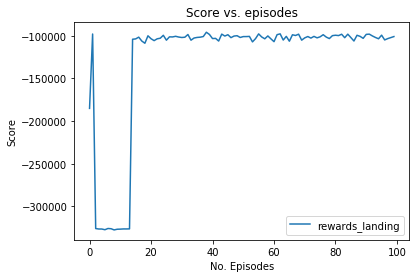

final_reward:  119.3545184338407


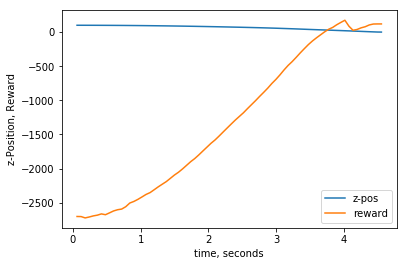

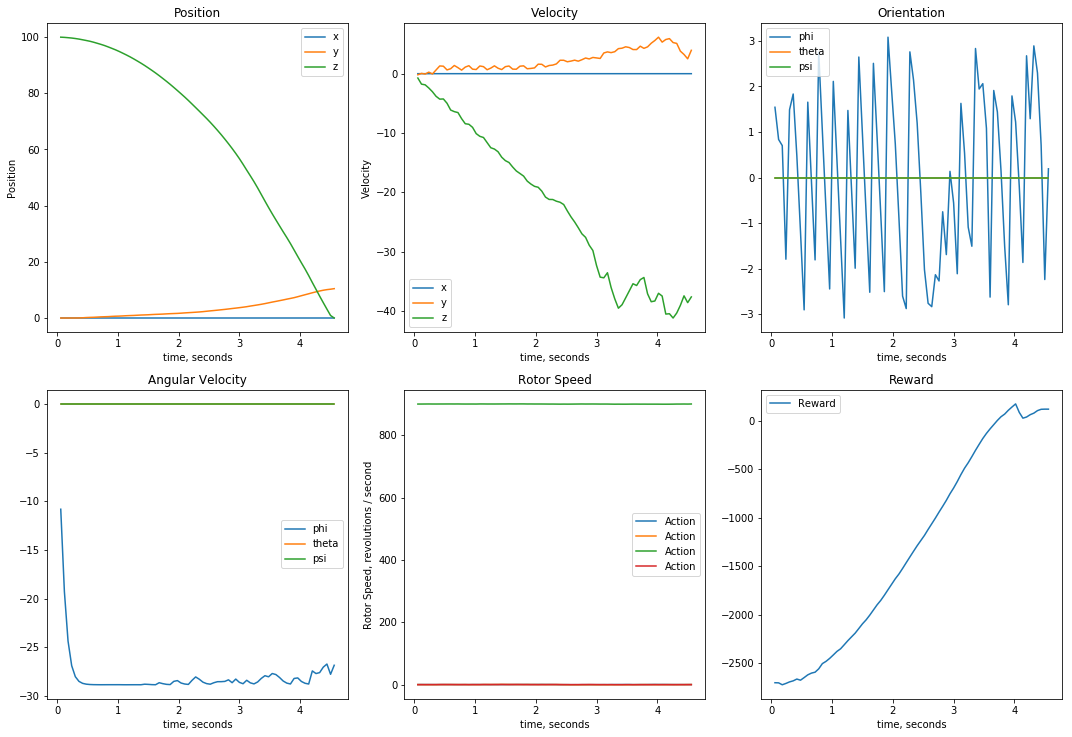

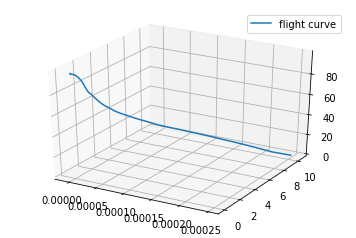

In [140]:
%matplotlib inline
utility.evaluate_episode(landing_agent, landing_scores, "landing")

#### END LANDING OPERATION

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

#### Tasks

I created 3 classes inherting from task describing: takeoff (start from [0,0,0] to [0,0,100]),  landing (start from [0,0,100] to [0,0,0]) and hovering (staying at [0,0,100]). Only takeoff and landing could be accomplished, hence I will only discuss the functions here. I extended the state: the original is comprised of sim.pose and euler angles, my extend version also includes velocities and angular_velocities in order to give more data to the neural networks. They can be found in the tasks folder

#### Reward function for takeoff:
The final reward consists of a base reward (100) and penalties for:
* residual distance for all axis x,y,z - each squared and with a 10x weight for the z-distance
* euler angle orientation different from 0,0,0 (weight: 100x); in order to stabilze the quadrocopter and preventing it from spinning
* velocity in x and y direction squared to discourage any movement in x or y direction
* velocity in z direction is only penalized when its in the same direction as the residual distance in z direction from the target; i.e. if the velocity direction points in the opposite of the z direction, i.e. in the z-direction of the target, indicating the residual z distance is going to be decreased in the next step, the penalty is smaller. E.g. if z = +10 and velo_z=-5 the penalty is (10-5)^2; squaring is done to emphasize larger distances with greater penalty
* angular velocity is also penalized; the penalty is reduced by any amount of euler angle in the direction of angular velocity; as the current euler angle deviation is going to be reduced by opposingly directing angular velocity; to penalize greate angular speed the values are squared as well; this is also to stabilze the quadrocopter and preventing it from spinning which it did strongly before introduction of this term.
* in case the quadrocopter surpased the targets z-coordinate as expressed by: self.sim.pose[2] >= self.target_pos[2]) an extra reward is granted; another extra reward is granted whether the subsequent distance from the target remains smaller than 5; this is to ensure some stability on reaching the target.

I tested a lot of combinations and there are still more things to try. There is still sometimes a significant distance in the x and y direction; also there the trajectory could be more monotonic and line-like. I found that this could be accomplished by setting the rotor-speed of all rotors to the same amount by simply restricting the action-space to a single action decribable by "speed of all 4 rotors". I abandoned this task as the real aim should be to control the quadrocopter by inidividually controlling all four rotors. I think this is more appropriate as for future applications; i.e. flying curves or reacting to other sensor-input (i.e. wind) the quadrocopter has to deal with all its rotos anyway and so do need I. I think it was most helpful to think about what the quadrocopter should do when it is taking off: i.e. velocity in z-direction, but in no other direction; getting slower on approaching the target; prevent spinning. To get the proportions right I think it would be helpful to dig deeper into the forces excerted on the rotors to spin, the quadrocopter on flying and its energetic cost towords achieving the aim. Maybe this would lead to an more approriate reward function. Mine is more the result of reasoning and trial and error.

#### Reward function for landing:
For the landing reward function I took a slighly different angle.
I defined a base-reward that is the absolute distance between the starting and the endpoint. Now, any further penalty is substracted from this base reward as follows:
* residual distance in x,y and z direction; with a 10x weight for the z-distance
* euler angle orientation different from 0,0,0 (weight: 10x); in order to stabilze the quadrocopter and preventing it from spinning
* any velocity in x and y direction was penalized; only negative velocity in z direction was penalized
* near target behaviour: Beginning the landing task, I encountered the quadrocopter to approach the grould with far to high speed. To prevent smashing of the theoretical quadrocpter I added additional penalty for velocity in z-direction (self.sim.v[2]**2) after the quadrocopter approached the target about 80% and another equal penality after approaching 90%
* finally I factorised the penalties (factor 0.01); I found that the absolute value of the penalties was to high to arrive at a reasonable learning behaviour, so I think.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

I used the DDPG, extending it using extend states (coordinates, euler angles and current velocity and angular velocity). To train different parameters I extended the class with a parameter param as a container for different values for sigma, batch_size, dropout_rate and NN-num_unit_multiplicator etc.
I ended up with:
* Noise Process: theta=0.15; sigma: 0.1
* ReplayBuffer size: 100000; batch_size: 64
* tau = 0.1; gamma = 0.99

As Actor Model Setup I used:
16 -> 32 -> 16 with relu and dropout of 0.2, l2 regularization with a lamdba of 0.01 as well as uniform initialization; 

As Critic Model Setup I used:
states: 32 -> 64
actions: 32 -> 64
both with: relu, dropout 0.2, l2 regularization with a lamdba of 0.01 as well as uniform initialization; 

I tried more layers after merging and could not find it to be usefull. I also tried a lot of different things; like a lot bigger and smaller networks, three instead of two layers; different value initialization as well as batch normalization. Although, I found no value in using batch_normalization here; I am still not sure whether dropout really yields a consistant advantage, but it seems to train more oftne successfully with than without.
I also tried different learning_rates as well as clipvalue; both had no real advantage.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

* This was the definetly the hardest project and part of the course; I e.g. read at least as much only for RL as for all other NN parts combined. Also specifically this project was very challening as there where so many possibilites to tweak hyperparameters. It made me wonder on using another neural network to just optimize all the hyperparameters :)
* An A-ha moment for me was that in this case the neural networks were not so important in the optimization than the reward functions; this cost me the most time. Another more trivial A-ha moment was initialization and seeding. I found that sometimes the whole system trains just on a specific seed, thus I tried different seeds and different initializations for the NNs. 
* The learning curve (here: the total reward summed up per episode an denoted as score) of scores over episode did not have a smooth profile, rather jumpy and sometimes very step. Looking at the numbers I could see that the algorithm was stuck on different values sometimes although there was already room for better score values. I found that a little puzzeling. If I would continue working on the project I would like to used a priorized Replay Buffer.
* The approx last 10 episodes for takeoff was between 20000-25000 (total range: 0-25000); for landing the last 10 epsisodes had values between -100000 (total range: -600000 and -100000). So both methods learnt a bit which can also be seen in the plots.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

* I think the hardest part was defining the reward functions. I would have liked to come up at something more general for both tasks and maybe also the hovering task. As stated before I guess, it would be helpful to incorporate other factors like forces or rotorspeeds directly into the the reward fuctions, maybe also some derivatives or at least change of velocity between steps or something like that. I am also puzzled by how easy the method gets stuck on certain values. Maybe an adaption of the sigma would help then? I tried somethink like that (i.e. raising sigma *X if reward increase is smaller than T), but it did not make into the final submission as it would have cost me to much time, now.
* I plotted the behaviour of the quadrocopter in 3d charts to get a grasp on what is going on. And I find it strange how the quadrcopter flys. But maybe this is at least partially due to the defined starting conditions. E.g. maybe I sould give the landing task init_velocities > 0.